# Setups

## Import

In [1]:
import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import torchsummary

from preprocess import *

## Load Data

In [2]:
%%time
df = Preprocess().preprocess()

Wall time: 48.3 s


# Setups

## Hyperparams

In [3]:
item_ids = list(chain(*df['assessmentItemID'].values))
test_ids = list(chain(*df['testId'].values))

In [4]:
cfg = {
    'seed': 42,
    'seq_len': 128,
    'tshold': 86400, # one day
    'model_cfg': {
        'num_items': len(set(item_ids)) + 1,
        'num_tests': len(set(test_ids)) + 1,
        'num_feats': len(df.columns),
        'num_consec': 2 + 1,
        'dropout': 0.1,
        'enc_layers': 2,
        'dec_layers': 2,
        'hidden': 32,
        'ff_model': 32 * 4, # hidden * 4
        'n_heads': 32 // 32,
        'tshold': 86400
    }
}

## Modeling

### Chunk

In [5]:
split = lambda data, split_size: np.split(data[:split_size], split_size // cfg['seq_len'])
pad = lambda row, pad_len: F.pad(torch.tensor(row), (0, pad_len), value=-1)

In [6]:
df.columns

Index(['assessmentItemID', 'testId', 'answerCode', 'Elapsed',
       'testConsecutive'],
      dtype='object')

**How to make Paddings**
+ `item` shift by 1, pad with 0
+ `test` shift by 1, pad with 0
+ `answer` ... 어쩌지 ㅅㅂ 그냥 shift? -> 2로 채움 일단
+ `Elapsed` 는 그냥 0으로 채워도 문제 없을 것...같기도함
+ `testConsec` 얘도 문제네... -> 2로 채움 일단

In [7]:
def shift_value(row):
    
    shifted_row = []
    for i, col in enumerate(row):
        
        if i in [0, 1]: # item, test        
            col = list(map(lambda x: x+1, col))
    
        else: # elapsed, answer, test_consec
            pass
        
        shifted_row.append(col)
        
    shifted_row = tuple(map(np.array, shifted_row))
    return shifted_row

In [8]:
def pad(row, pad_len):
    
    padded_row = []
    for i, col in enumerate(row):
        
        if i in [0, 1, 3]: # item, test, elapsed
            
            col = F.pad(torch.tensor(col), (0, pad_len), value=0).numpy()
        
        elif i in [2, 4]: # answer, test_consec
            
            col = F.pad(torch.tensor(col), (0, pad_len), value=2).numpy()
            
        else:
            pass
        
        padded_row.append(col)
        
    return padded_row

In [9]:
chunked_data = []
for row in df.values:
    
    row = shift_value(row)    
    
    if len(row[0]) >= cfg['seq_len']:
        
        split_size = len(row[0]) - len(row[0])%cfg['seq_len']        
        # TODO: simple and clean. Currently,,, only simple
        chunked_data.extend(list(zip(*map(split, row, [split_size]*cfg['model_cfg']['num_feats']))))
        
    elif len(row[0]) < cfg['seq_len']:
        
        pad_len = cfg['seq_len'] - len(row[0])
        chunked_data.append(tuple(pad(row, pad_len)))
        
    else:
        pass
        
chunked_data = pd.Series(chunked_data)

### DataLoader

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

In [11]:
class IscreamDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return tuple(torch.LongTensor(feat) for feat in self.data[index])
    
    def __len__(self):
        return len(self.data)

In [12]:
def collate_fn_short(batch):
    
    batchify = lambda idx: torch.cat([b[idx].unsqueeze(1) for b in batch], dim=1)
    return [batchify(i) for i in range(cfg['model_cfg']['num_feats'])]

In [13]:
from sklearn.model_selection import train_test_split

train_chunk, valid_chunk = train_test_split(chunked_data, test_size=0.2, random_state=cfg['seed'])

In [14]:
valid_chunk.reset_index(drop=True, inplace=True)

In [15]:
train_chunk.reset_index(drop=True, inplace=True)

In [16]:
pin_memory = False

trainset = IscreamDataset(train_chunk)
train_loader = DataLoader(trainset, shuffle=False,
                          batch_size=16,
                          drop_last=True,
                          pin_memory=True,
                          collate_fn=collate_fn_short)

validset = IscreamDataset(valid_chunk)
valid_loader = DataLoader(validset, shuffle=False,
                          batch_size=16,
                          drop_last=False,
                          pin_memory=True,
                          collate_fn=collate_fn_short)

In [17]:
batch = next(iter(train_loader))

### Model

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
from torch.autograd import Variable

import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer

In [20]:
from utils import PositionalEncoding, NoamOpt

In [21]:
class Saintplus(nn.Module):
    '''
    Try to Implement SAINT+
    ENCODER::
        + AssessmentItemID
        + TestID
        + Consecutive Test
        + Positional Encoding
        
    DECODER::
        + Correctness
        + Lag Time Encoding
        + Positional Encoding
    '''
    def __init__(self, cfg):
        super(Saintplus, self).__init__()
        
        self.cfg = cfg
        hidden = cfg['hidden']
        dropout = cfg['dropout']
        # Encoders' Embeddings
        self.item_emb = nn.Embedding(cfg['num_items'], hidden)
        self.test_emb = nn.Embedding(cfg['num_tests'], hidden)
        self.cons_emb = nn.Embedding(cfg['num_consec'], hidden)
        self.pos_enc = PositionalEncoding(hidden, dropout)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        
        # Decoders' Embeddings
        self.ans_emb = nn.Embedding(3, hidden)
        self.lag_emb = nn.Embedding(cfg['tshold'], hidden)
        self.pos_dec = PositionalEncoding(hidden, dropout) 
        
        self.dropout_4 = nn.Dropout(dropout)
        self.dropout_5 = nn.Dropout(dropout)
        
        self.src_mask = None
        self.trg_mask = None
        self.memory_mask = None # TODO:
        
        self.transformer = nn.Transformer(d_model=hidden,
                                         nhead=cfg['n_heads'],
                                         num_encoder_layers=cfg['enc_layers'],
                                         num_decoder_layers=cfg['dec_layers'],
                                         dim_feedforward=cfg['ff_model'],
                                         dropout=dropout,
                                         activation='relu')
        
        self.fc_out = nn.Linear(hidden, 1)
        self.softmax = nn.Softmax()
        
        
    def generate_square_subsequent_mask(self, sz, sz1=None):
        
        if sz1 == None:
            mask = torch.triu(torch.ones(sz, sz), 1)
        else:
            mask = torch.triu(torch.ones(sz, sz1), 1)
            
        return mask.masked_fill(mask==1, float('-inf'))

    
    def forward(self, item, test, ans, lag, consec):
        
        # Encoder Embeddings
        src = self.dropout_1(self.item_emb(item))
        test_emb = self.dropout_2(self.test_emb(test))
        cons_emb = self.dropout_3(self.cons_emb(consec))
        
        src = torch.add(src, test_emb)
        src = torch.add(src, cons_emb)
        src = self.pos_enc(src)
        
        # Decoder Embeddings
        trg = self.dropout_4(self.ans_emb(ans))
        lag_emb = self.dropout_5(self.lag_emb(lag))
        trg = torch.add(trg, lag_emb)
        trg = self.pos_dec(trg)
        
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(len(trg)).to(trg.device)
            
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            self.src_mask = self.generate_square_subsequent_mask(len(src)).to(trg.device)
            
        if self.memory_mask is None or self.memory_mask.size(0) != len(trg) or self.memory_mask.size(1) != len(src):
            self.memory_mask = self.generate_square_subsequent_mask(len(trg),len(src)).to(trg.device)
        
        output = self.transformer(src, trg,
#                                  src_mask=self.src_mask,
                                 tgt_mask=self.trg_mask,)
#                                  memory_mask=self.memory_mask)
        
        output = self.fc_out(output)
        return output

Always remember that batch consists in the following order
+ Item   -> encoder
+ Test   -> encoder
+ Ans    -> decoder
+ Lag    -> decoder
+ Consec -> encoder

In [22]:
model = Saintplus(cfg['model_cfg'])
model.to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

3176323


In [23]:
loss_fn = nn.BCEWithLogitsLoss()
# optimizer = NoamOpt(cfg['model_cfg']['hidden'], 1, 4000, optim.Adam(model.parameters(), lr=0))
# optimizer = optim.Adam(model.parameters(), lr=1e+1)
optimizer = optim.SGD(model.parameters(), lr=1)

In [24]:
def add_shift(var, pad_value, device):
    
    return torch.cat([torch.LongTensor(1, var.shape[1]).fill_(pad_value).to(device), var])

Epoch 1 / 10
Epoch Loss: 0.56999
Answer Rate: 0.58034
Validation Result
Epoch Loss: 0.55094
Answer Rate: 0.58238


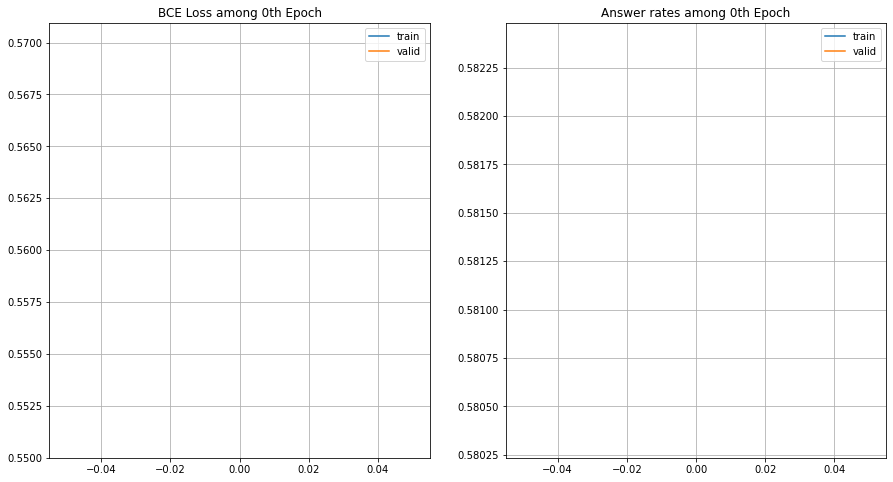

Epoch 2 / 10
Epoch Loss: 0.55016
Answer Rate: 0.58830
Validation Result
Epoch Loss: 0.54609
Answer Rate: 0.58714
Epoch 3 / 10
Epoch Loss: 0.54710
Answer Rate: 0.58932
Validation Result
Epoch Loss: 0.54439
Answer Rate: 0.58777
Epoch 4 / 10
Epoch Loss: 0.54565
Answer Rate: 0.58948
Validation Result
Epoch Loss: 0.54343
Answer Rate: 0.58739
Epoch 5 / 10
Epoch Loss: 0.54467
Answer Rate: 0.58954
Validation Result
Epoch Loss: 0.54268
Answer Rate: 0.58778
Epoch 6 / 10
Epoch Loss: 0.54386
Answer Rate: 0.58964
Validation Result
Epoch Loss: 0.54206
Answer Rate: 0.58818


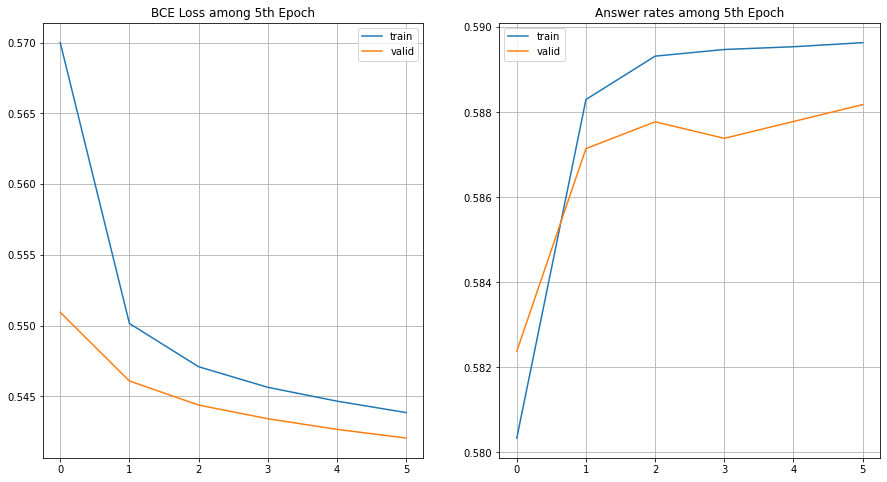

Epoch 7 / 10
Epoch Loss: 0.54315
Answer Rate: 0.58978
Validation Result
Epoch Loss: 0.54155
Answer Rate: 0.58873
Epoch 8 / 10
Epoch Loss: 0.54250
Answer Rate: 0.58990
Validation Result
Epoch Loss: 0.54113
Answer Rate: 0.58946
Epoch 9 / 10
Epoch Loss: 0.54188
Answer Rate: 0.58998
Validation Result
Epoch Loss: 0.54069
Answer Rate: 0.59051
Epoch 10 / 10
Epoch Loss: 0.54124
Answer Rate: 0.59013
Validation Result
Epoch Loss: 0.54021
Answer Rate: 0.59062
Epoch 11 / 10
Epoch Loss: 0.54060
Answer Rate: 0.59025
Validation Result
Epoch Loss: 0.53971
Answer Rate: 0.59128


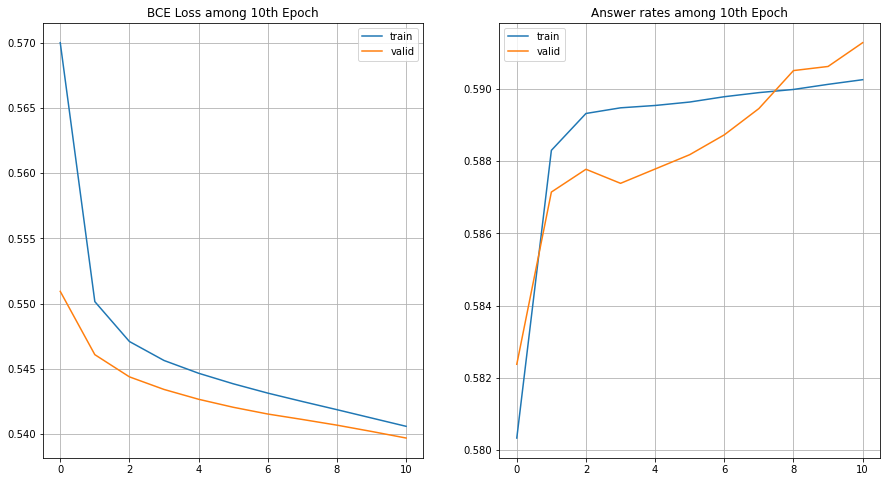

Epoch 12 / 10
Epoch Loss: 0.53999
Answer Rate: 0.59032
Validation Result
Epoch Loss: 0.53926
Answer Rate: 0.59199
Epoch 13 / 10
Epoch Loss: 0.53943
Answer Rate: 0.59039
Validation Result
Epoch Loss: 0.53892
Answer Rate: 0.59218
Epoch 14 / 10
Epoch Loss: 0.53892
Answer Rate: 0.59053
Validation Result
Epoch Loss: 0.53864
Answer Rate: 0.59215
Epoch 15 / 10
Epoch Loss: 0.53848
Answer Rate: 0.59059
Validation Result
Epoch Loss: 0.53845
Answer Rate: 0.59270
Epoch 16 / 10
Epoch Loss: 0.53810
Answer Rate: 0.59063
Validation Result
Epoch Loss: 0.53831
Answer Rate: 0.59297


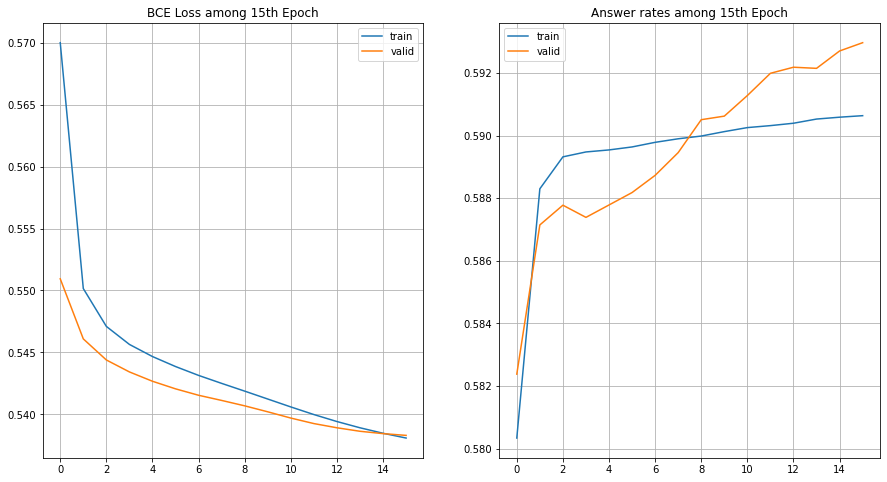

Epoch 17 / 10
Epoch Loss: 0.53775
Answer Rate: 0.59067
Validation Result
Epoch Loss: 0.53818
Answer Rate: 0.59279
Epoch 18 / 10
Epoch Loss: 0.53744
Answer Rate: 0.59069
Validation Result
Epoch Loss: 0.53812
Answer Rate: 0.59273
Epoch 19 / 10
Epoch Loss: 0.53715
Answer Rate: 0.59067
Validation Result
Epoch Loss: 0.53812
Answer Rate: 0.59347
Epoch 20 / 10
Epoch Loss: 0.53688
Answer Rate: 0.59069
Validation Result
Epoch Loss: 0.53809
Answer Rate: 0.59324
Epoch 21 / 10
Epoch Loss: 0.53663
Answer Rate: 0.59066
Validation Result
Epoch Loss: 0.53806
Answer Rate: 0.59348


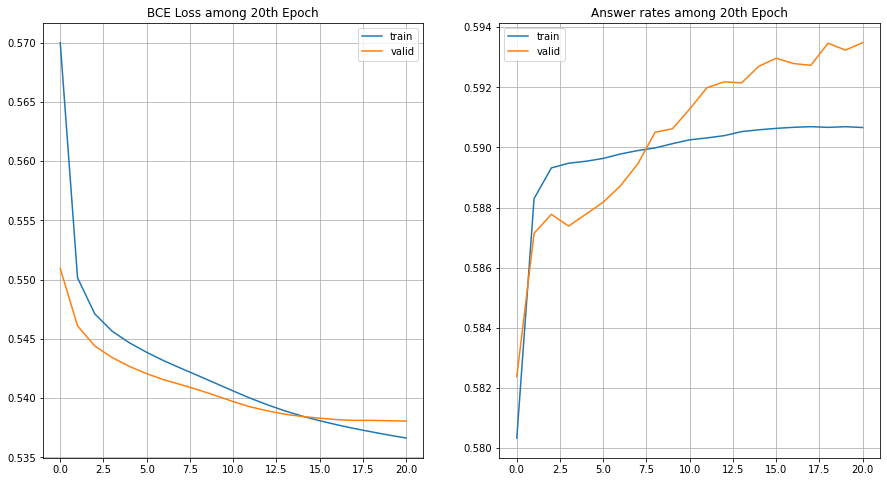

Epoch 22 / 10
Epoch Loss: 0.53639
Answer Rate: 0.59066
Validation Result
Epoch Loss: 0.53807
Answer Rate: 0.59385
Epoch 23 / 10
Epoch Loss: 0.53617
Answer Rate: 0.59061
Validation Result
Epoch Loss: 0.53804
Answer Rate: 0.59410
Epoch 24 / 10
Epoch Loss: 0.53596
Answer Rate: 0.59070
Validation Result
Epoch Loss: 0.53809
Answer Rate: 0.59413
Epoch 25 / 10
Epoch Loss: 0.53575
Answer Rate: 0.59072
Validation Result
Epoch Loss: 0.53809
Answer Rate: 0.59414
Epoch 26 / 10
Epoch Loss: 0.53553
Answer Rate: 0.59071
Validation Result
Epoch Loss: 0.53819
Answer Rate: 0.59427


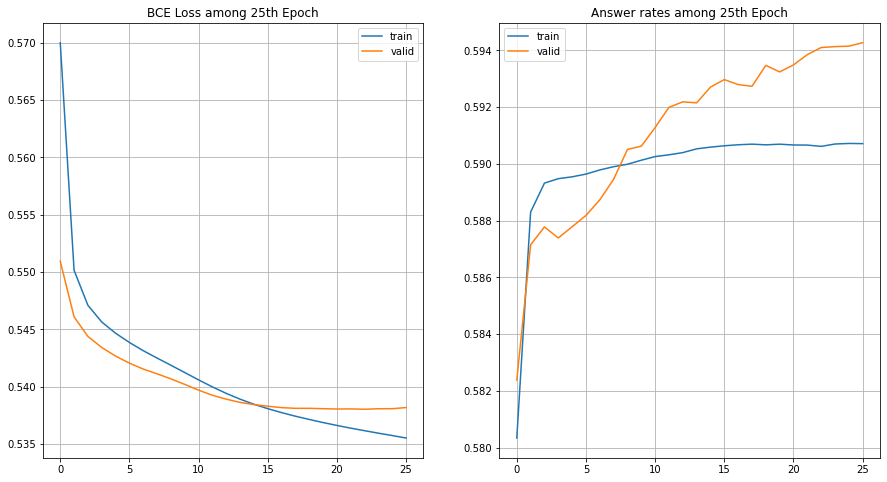

Epoch 27 / 10
Epoch Loss: 0.53533
Answer Rate: 0.59068
Validation Result
Epoch Loss: 0.53828
Answer Rate: 0.59413
Epoch 28 / 10
Epoch Loss: 0.53513
Answer Rate: 0.59069
Validation Result
Epoch Loss: 0.53827
Answer Rate: 0.59364
Epoch 29 / 10
Epoch Loss: 0.53493
Answer Rate: 0.59071
Validation Result
Epoch Loss: 0.53840
Answer Rate: 0.59401
Epoch 30 / 10
Epoch Loss: 0.53474
Answer Rate: 0.59065
Validation Result
Epoch Loss: 0.53843
Answer Rate: 0.59394
Epoch 31 / 10
Epoch Loss: 0.53454
Answer Rate: 0.59061
Validation Result
Epoch Loss: 0.53848
Answer Rate: 0.59389


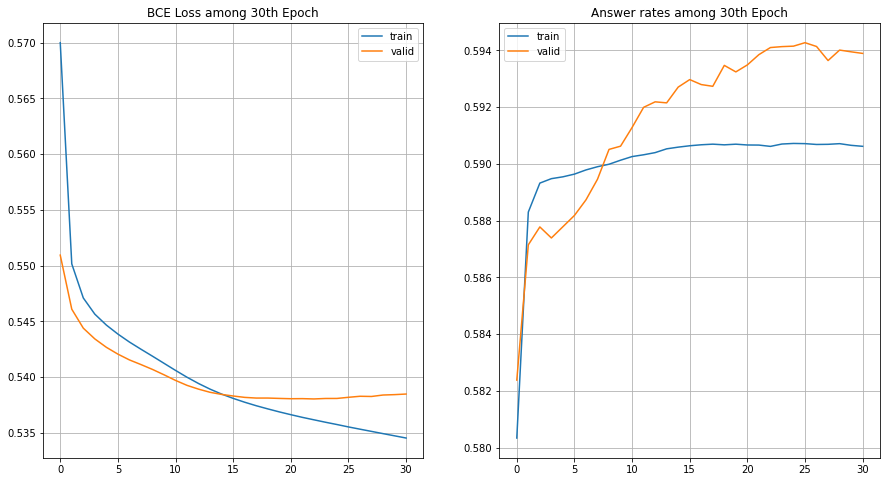

Epoch 32 / 10
Epoch Loss: 0.53435
Answer Rate: 0.59058
Validation Result
Epoch Loss: 0.53856
Answer Rate: 0.59391
Epoch 33 / 10
Epoch Loss: 0.53417
Answer Rate: 0.59056
Validation Result
Epoch Loss: 0.53870
Answer Rate: 0.59426
Epoch 34 / 10
Epoch Loss: 0.53397
Answer Rate: 0.59058
Validation Result
Epoch Loss: 0.53879
Answer Rate: 0.59464
Epoch 35 / 10
Epoch Loss: 0.53378
Answer Rate: 0.59063
Validation Result
Epoch Loss: 0.53910
Answer Rate: 0.59475
Epoch 36 / 10
Epoch Loss: 0.53358
Answer Rate: 0.59063
Validation Result
Epoch Loss: 0.53935
Answer Rate: 0.59525


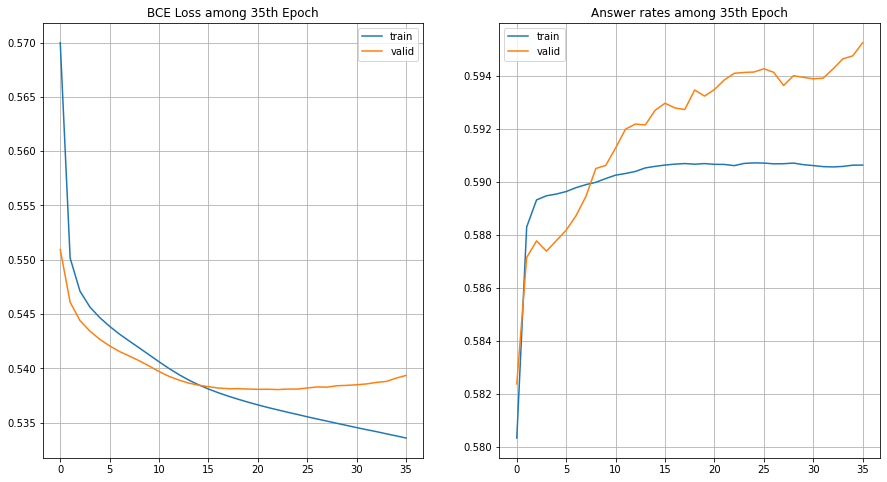

Epoch 37 / 10
Epoch Loss: 0.53339
Answer Rate: 0.59058
Validation Result
Epoch Loss: 0.53960
Answer Rate: 0.59578
Epoch 38 / 10
Epoch Loss: 0.53320
Answer Rate: 0.59060
Validation Result
Epoch Loss: 0.53984
Answer Rate: 0.59612
Epoch 39 / 10
Epoch Loss: 0.53299
Answer Rate: 0.59061
Validation Result
Epoch Loss: 0.54003
Answer Rate: 0.59643
Epoch 40 / 10
Epoch Loss: 0.53277
Answer Rate: 0.59052
Validation Result
Epoch Loss: 0.54032
Answer Rate: 0.59688
Epoch 41 / 10
Epoch Loss: 0.53255
Answer Rate: 0.59054
Validation Result
Epoch Loss: 0.54063
Answer Rate: 0.59689


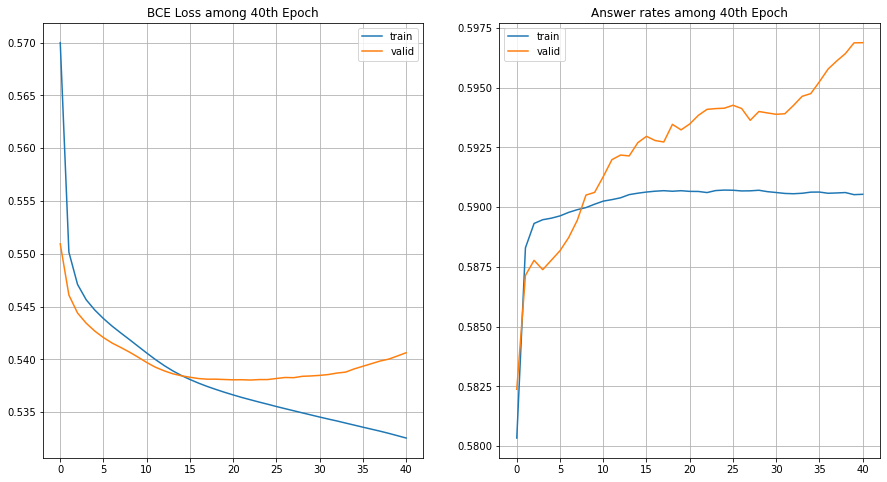

Epoch 42 / 10
Epoch Loss: 0.53234
Answer Rate: 0.59055
Validation Result
Epoch Loss: 0.54083
Answer Rate: 0.59700
Epoch 43 / 10
Epoch Loss: 0.53214
Answer Rate: 0.59055
Validation Result
Epoch Loss: 0.54113
Answer Rate: 0.59771
Epoch 44 / 10
Epoch Loss: 0.53194
Answer Rate: 0.59057
Validation Result
Epoch Loss: 0.54129
Answer Rate: 0.59705
Epoch 45 / 10
Epoch Loss: 0.53171
Answer Rate: 0.59056
Validation Result
Epoch Loss: 0.54214
Answer Rate: 0.59870
Epoch 46 / 10
Epoch Loss: 0.53148
Answer Rate: 0.59060
Validation Result
Epoch Loss: 0.54267
Answer Rate: 0.59896


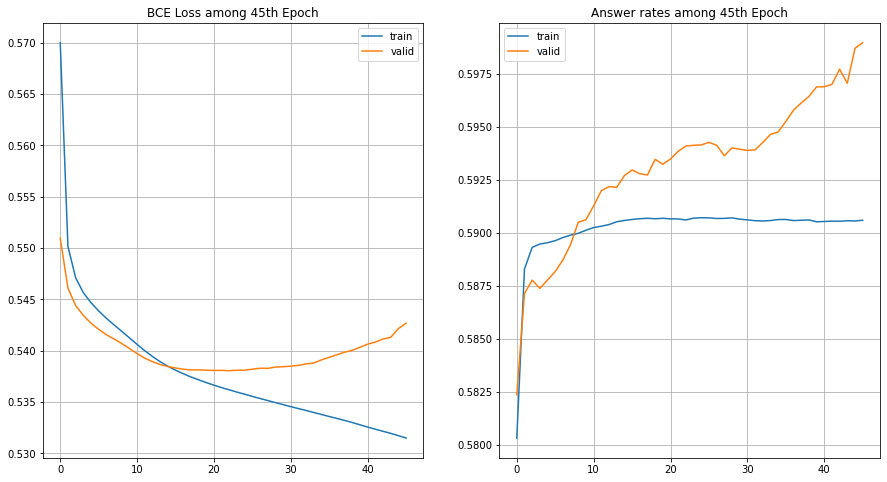

Epoch 47 / 10
Epoch Loss: 0.53126
Answer Rate: 0.59052
Validation Result
Epoch Loss: 0.54277
Answer Rate: 0.59851
Epoch 48 / 10
Epoch Loss: 0.53102
Answer Rate: 0.59057
Validation Result
Epoch Loss: 0.54356
Answer Rate: 0.59959
Epoch 49 / 10
Epoch Loss: 0.53083
Answer Rate: 0.59059
Validation Result
Epoch Loss: 0.54339
Answer Rate: 0.59739
Epoch 50 / 10
Epoch Loss: 0.53059
Answer Rate: 0.59054
Validation Result
Epoch Loss: 0.54434
Answer Rate: 0.59832
Epoch 51 / 10
Epoch Loss: 0.53041
Answer Rate: 0.59053
Validation Result
Epoch Loss: 0.54407
Answer Rate: 0.59736


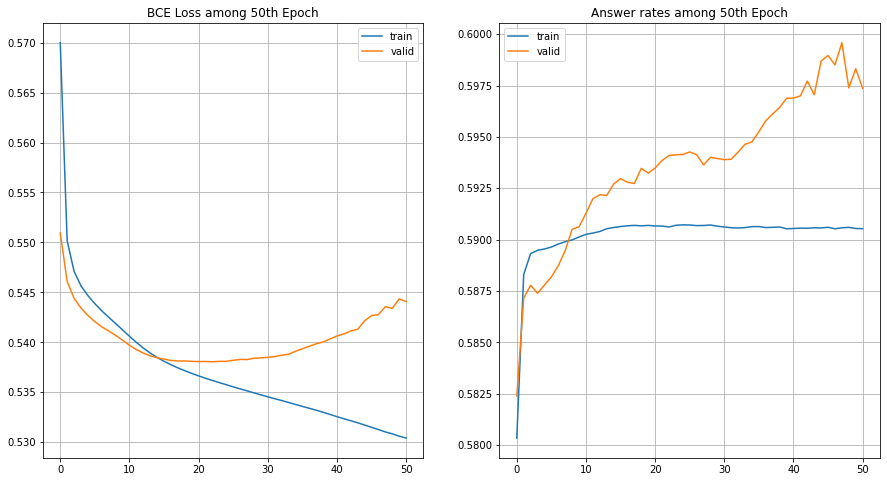

Epoch 52 / 10
Epoch Loss: 0.53019
Answer Rate: 0.59058
Validation Result
Epoch Loss: 0.54484
Answer Rate: 0.59768
Epoch 53 / 10
Epoch Loss: 0.53002
Answer Rate: 0.59054
Validation Result
Epoch Loss: 0.54501
Answer Rate: 0.59764
Epoch 54 / 10
Epoch Loss: 0.52981
Answer Rate: 0.59060
Validation Result
Epoch Loss: 0.54537
Answer Rate: 0.59881
Epoch 55 / 10
Epoch Loss: 0.52961
Answer Rate: 0.59057
Validation Result
Epoch Loss: 0.54540
Answer Rate: 0.59765
Epoch 56 / 10
Epoch Loss: 0.52944
Answer Rate: 0.59056
Validation Result
Epoch Loss: 0.54546
Answer Rate: 0.59684


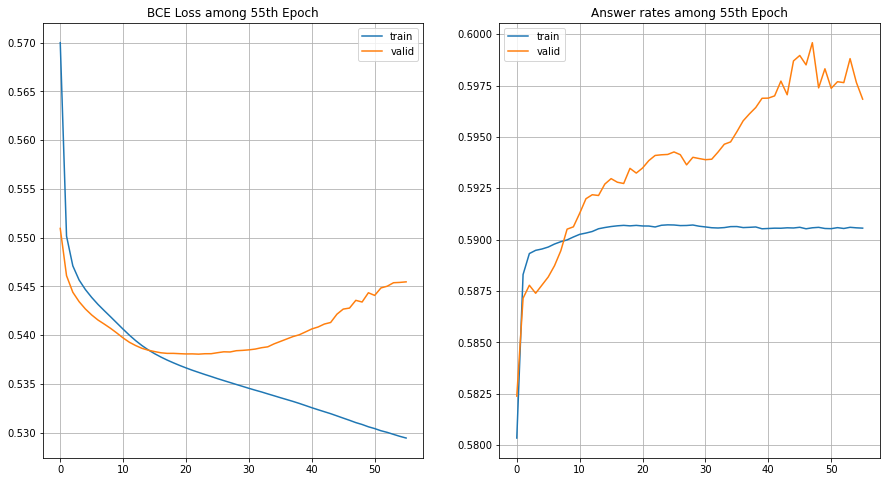

Epoch 57 / 10
Epoch Loss: 0.52923
Answer Rate: 0.59056
Validation Result
Epoch Loss: 0.54650
Answer Rate: 0.59806
Epoch 58 / 10
Epoch Loss: 0.52902
Answer Rate: 0.59061
Validation Result
Epoch Loss: 0.54633
Answer Rate: 0.59711
Epoch 59 / 10
Epoch Loss: 0.52891
Answer Rate: 0.59057
Validation Result
Epoch Loss: 0.54598
Answer Rate: 0.59616
Epoch 60 / 10
Epoch Loss: 0.52876
Answer Rate: 0.59060
Validation Result
Epoch Loss: 0.54686
Answer Rate: 0.59766
Epoch 61 / 10
Epoch Loss: 0.52857
Answer Rate: 0.59070
Validation Result
Epoch Loss: 0.54779
Answer Rate: 0.59721


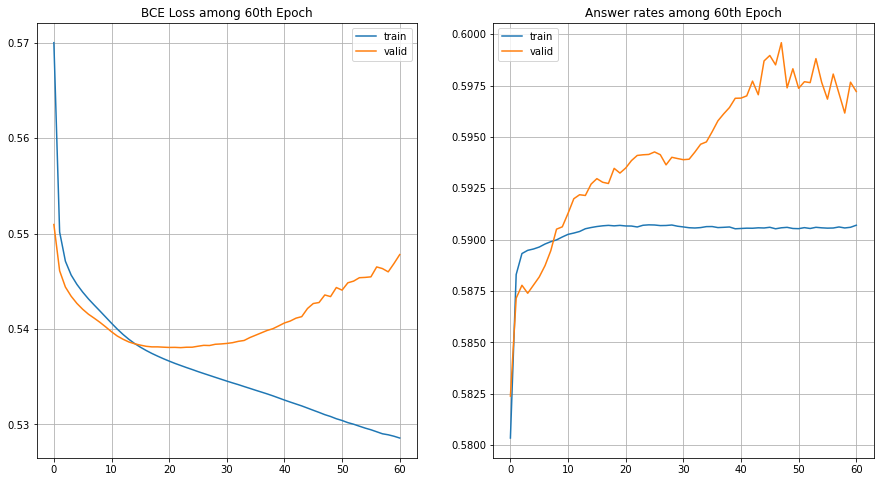

Epoch 62 / 10
Epoch Loss: 0.52845
Answer Rate: 0.59055
Validation Result
Epoch Loss: 0.54653
Answer Rate: 0.59600
Epoch 63 / 10
Epoch Loss: 0.52832
Answer Rate: 0.59056
Validation Result
Epoch Loss: 0.54662
Answer Rate: 0.59647
Epoch 64 / 10
Epoch Loss: 0.52818
Answer Rate: 0.59056
Validation Result
Epoch Loss: 0.54728
Answer Rate: 0.59774
Epoch 65 / 10
Epoch Loss: 0.52795
Answer Rate: 0.59066
Validation Result
Epoch Loss: 0.55065
Answer Rate: 0.60016
Epoch 66 / 10
Epoch Loss: 0.52784
Answer Rate: 0.59069
Validation Result
Epoch Loss: 0.54693
Answer Rate: 0.59518


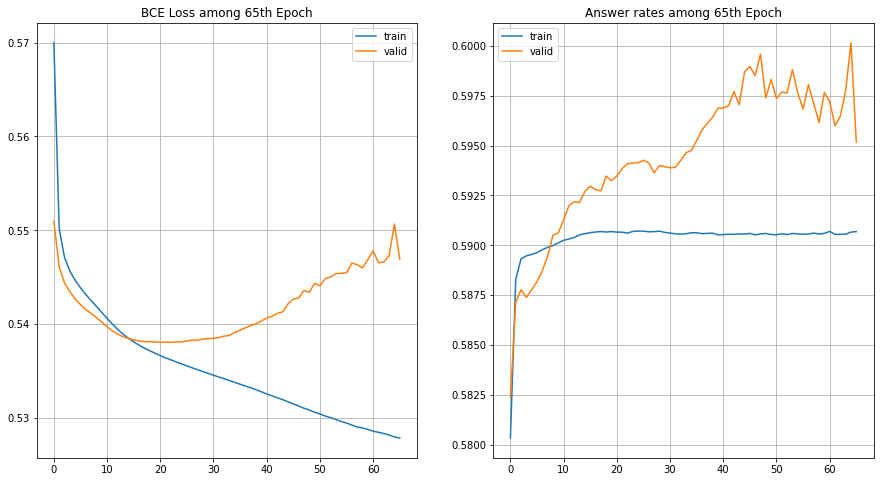

Epoch 67 / 10
Epoch Loss: 0.52773
Answer Rate: 0.59066
Validation Result
Epoch Loss: 0.54764
Answer Rate: 0.59905
Epoch 68 / 10
Epoch Loss: 0.52759
Answer Rate: 0.59046
Validation Result
Epoch Loss: 0.54875
Answer Rate: 0.59951
Epoch 69 / 10
Epoch Loss: 0.52742
Answer Rate: 0.59052
Validation Result
Epoch Loss: 0.54844
Answer Rate: 0.59965
Epoch 70 / 10
Epoch Loss: 0.52734
Answer Rate: 0.59045
Validation Result
Epoch Loss: 0.54717
Answer Rate: 0.59754
Epoch 71 / 10
Epoch Loss: 0.52722
Answer Rate: 0.59049
Validation Result
Epoch Loss: 0.54799
Answer Rate: 0.59940


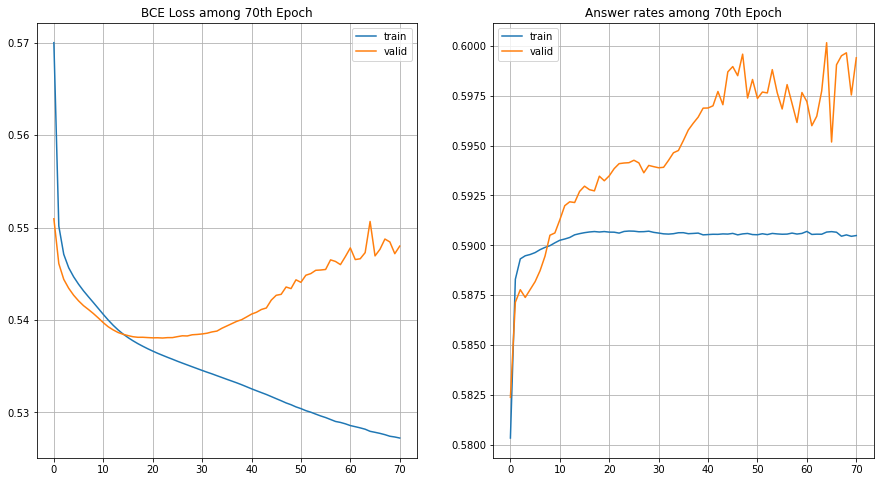

Epoch 72 / 10
Epoch Loss: 0.52702
Answer Rate: 0.59047
Validation Result
Epoch Loss: 0.54976
Answer Rate: 0.60007
Epoch 73 / 10
Epoch Loss: 0.52684
Answer Rate: 0.59045
Validation Result
Epoch Loss: 0.54767
Answer Rate: 0.59634
Epoch 74 / 10
Epoch Loss: 0.52677
Answer Rate: 0.59047
Validation Result
Epoch Loss: 0.54911
Answer Rate: 0.59857
Epoch 75 / 10
Epoch Loss: 0.52664
Answer Rate: 0.59040
Validation Result
Epoch Loss: 0.54969
Answer Rate: 0.59883
Epoch 76 / 10
Epoch Loss: 0.52652
Answer Rate: 0.59033
Validation Result
Epoch Loss: 0.55087
Answer Rate: 0.59892


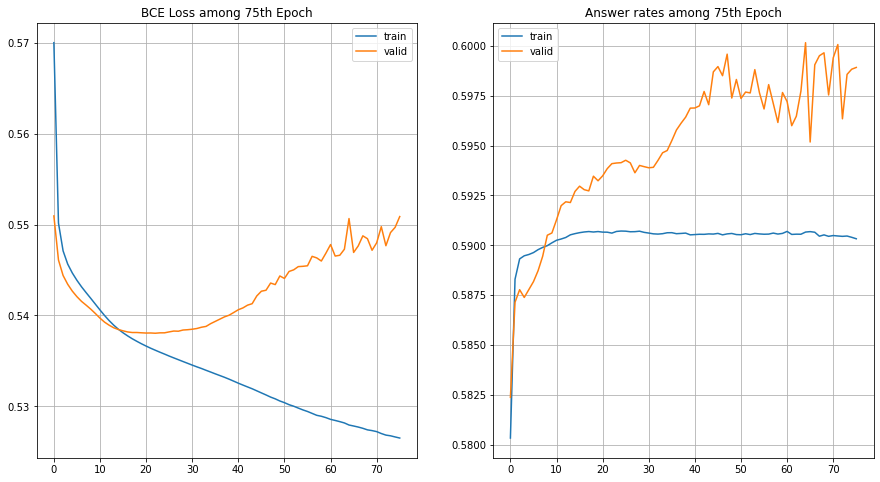

Epoch 77 / 10
Epoch Loss: 0.52640
Answer Rate: 0.59033
Validation Result
Epoch Loss: 0.55030
Answer Rate: 0.59900
Epoch 78 / 10
Epoch Loss: 0.52632
Answer Rate: 0.59020
Validation Result
Epoch Loss: 0.54858
Answer Rate: 0.59504
Epoch 79 / 10
Epoch Loss: 0.52622
Answer Rate: 0.59016
Validation Result
Epoch Loss: 0.55029
Answer Rate: 0.59647
Epoch 80 / 10
Epoch Loss: 0.52619
Answer Rate: 0.59029
Validation Result
Epoch Loss: 0.55098
Answer Rate: 0.59920
Epoch 81 / 10
Epoch Loss: 0.52600
Answer Rate: 0.59031
Validation Result
Epoch Loss: 0.55065
Answer Rate: 0.59772


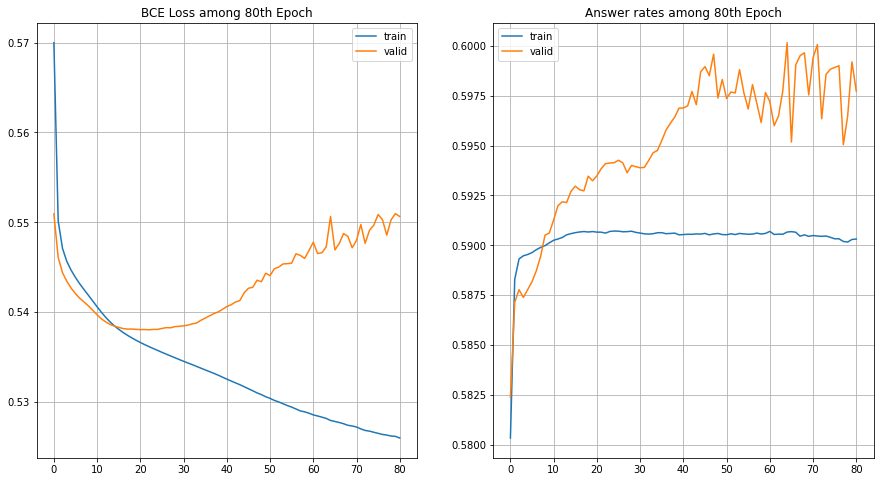

Epoch 82 / 10
Epoch Loss: 0.52586
Answer Rate: 0.59023
Validation Result
Epoch Loss: 0.55002
Answer Rate: 0.59825
Epoch 83 / 10
Epoch Loss: 0.52579
Answer Rate: 0.59031
Validation Result
Epoch Loss: 0.55003
Answer Rate: 0.59757
Epoch 84 / 10
Epoch Loss: 0.52566
Answer Rate: 0.59019
Validation Result
Epoch Loss: 0.54979
Answer Rate: 0.59912
Epoch 85 / 10
Epoch Loss: 0.52555
Answer Rate: 0.59026
Validation Result
Epoch Loss: 0.55035
Answer Rate: 0.59961
Epoch 86 / 10
Epoch Loss: 0.52545
Answer Rate: 0.59033
Validation Result
Epoch Loss: 0.55111
Answer Rate: 0.60133


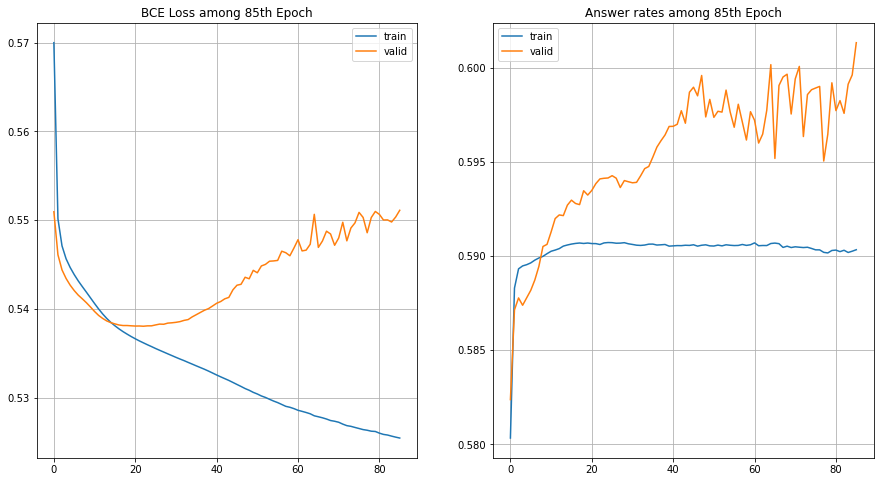

Epoch 87 / 10
Epoch Loss: 0.52543
Answer Rate: 0.59019
Validation Result
Epoch Loss: 0.54952
Answer Rate: 0.59639
Epoch 88 / 10
Epoch Loss: 0.52528
Answer Rate: 0.59009
Validation Result
Epoch Loss: 0.54951
Answer Rate: 0.59677
Epoch 89 / 10
Epoch Loss: 0.52523
Answer Rate: 0.59031
Validation Result
Epoch Loss: 0.54970
Answer Rate: 0.59736
Epoch 90 / 10
Epoch Loss: 0.52504
Answer Rate: 0.59019
Validation Result
Epoch Loss: 0.54806
Answer Rate: 0.59524
Epoch 91 / 10
Epoch Loss: 0.52484
Answer Rate: 0.59008
Validation Result
Epoch Loss: 0.55024
Answer Rate: 0.59724


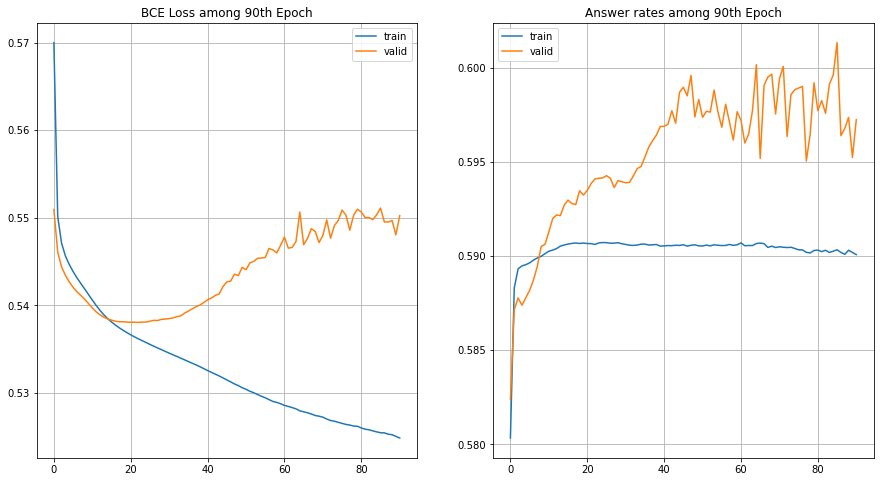

Epoch 92 / 10
Epoch Loss: 0.52492
Answer Rate: 0.59014
Validation Result
Epoch Loss: 0.55025
Answer Rate: 0.59566
Epoch 93 / 10
Epoch Loss: 0.52475
Answer Rate: 0.59015
Validation Result
Epoch Loss: 0.55097
Answer Rate: 0.59627
Epoch 94 / 10
Epoch Loss: 0.52478
Answer Rate: 0.59030
Validation Result
Epoch Loss: 0.55423
Answer Rate: 0.60244
Epoch 95 / 10
Epoch Loss: 0.52466
Answer Rate: 0.59036
Validation Result
Epoch Loss: 0.55197
Answer Rate: 0.59752
Epoch 96 / 10
Epoch Loss: 0.52447
Answer Rate: 0.59028
Validation Result
Epoch Loss: 0.55097
Answer Rate: 0.59672


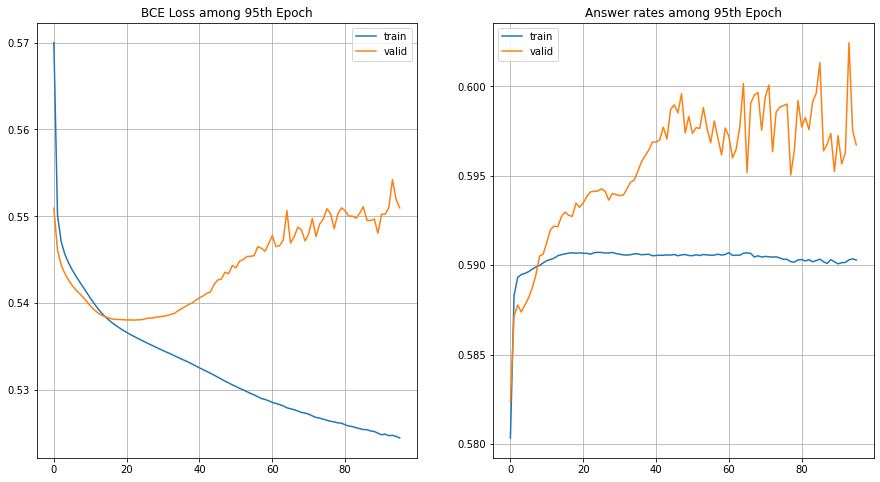

Epoch 97 / 10
Epoch Loss: 0.52443
Answer Rate: 0.59033
Validation Result
Epoch Loss: 0.55049
Answer Rate: 0.59575
Epoch 98 / 10
Epoch Loss: 0.52439
Answer Rate: 0.59036
Validation Result
Epoch Loss: 0.55083
Answer Rate: 0.59710
Epoch 99 / 10
Epoch Loss: 0.52430
Answer Rate: 0.59025
Validation Result
Epoch Loss: 0.55025
Answer Rate: 0.59671
Epoch 100 / 10
Epoch Loss: 0.52405
Answer Rate: 0.59009
Validation Result
Epoch Loss: 0.55111
Answer Rate: 0.59628


In [25]:
model.train()
trn_losses, val_losses = [], []
trn_ans, val_ans = [], []
for e in range(100):
    epoch_loss = 0
    answer_rates = []
    for i, batch in enumerate(train_loader):

        item, test, ans, lag, consec = map(lambda x: x.to(device), batch)
    #     item, test, ans, lag, consec = batch

        ans = add_shift(ans, 2, device).to(device)
        lag = add_shift(lag, 0, device).to(device)

        optimizer.zero_grad()
        output = model(item, test, ans[:-1, :], lag[:-1, :], consec)

        idx = ans[1:, :] != 2
#         ans_logit = torch.Tensor([[0, 1] if logit else [1, 0] for logit in ans[1:, :][idx]]).to(device)
        loss = loss_fn(output.squeeze()[idx], ans[1:, :][idx].float())

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        pred = output.squeeze()[idx]
        true = ans[1:, :][idx]
        correct = true & (nn.Sigmoid()(pred) > 0.5)
        
#         correct = true.cpu().numpy() & pred.argmax(axis=1).cpu().numpy()
        answer_rate = correct[correct == 1].shape[0] / correct.shape[0]
        answer_rates.append(answer_rate)

        epoch_loss += loss.item()
    
    print(f'Epoch {e+1} / 10')
    print(f'Epoch Loss: {epoch_loss / len(train_loader):.5f}')
    trn_losses.append(epoch_loss / len(train_loader))
    
    mean_ans = np.array(answer_rates).mean()
    trn_ans.append(mean_ans)
    print(f'Answer Rate: {mean_ans:.5f}')
    
    model.eval()
    epoch_loss = 0
    answer_rates = []
    for i, batch in enumerate(valid_loader):

        item, test, ans, lag, consec = map(lambda x: x.to(device), batch)

        ans = add_shift(ans, 2, device).to(device)
        lag = add_shift(lag, 0, device).to(device)

        optimizer.zero_grad()
        output = model(item, test, ans[:-1, :], lag[:-1, :], consec)

        idx = ans[1:, :] != 2
        loss = loss_fn(output.squeeze()[idx], ans[1:, :][idx].float())

        pred = output.squeeze()[idx]
        true = ans[1:, :][idx]
        correct = true & (nn.Sigmoid()(pred) > 0.5)

        answer_rate = correct[correct == 1].shape[0] / correct.shape[0]
        answer_rates.append(answer_rate)

        epoch_loss += loss.item()

    print('Validation Result')
    print(f'Epoch Loss: {epoch_loss / len(valid_loader):.5f}')
    val_losses.append(epoch_loss / len(valid_loader))

    mean_ans = np.array(answer_rates).mean()
    print(f'Answer Rate: {mean_ans:.5f}')
    val_ans.append(mean_ans)
    
    if e % 5 == 0:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
        ax[0].set_title(f'BCE Loss among {e}th Epoch')
        ax[0].plot(trn_losses, label='train')
        ax[0].plot(val_losses, label='valid')
        ax[0].grid()
        ax[0].legend()
        
        ax[1].set_title(f'Answer rates among {e}th Epoch')
        ax[1].plot(trn_ans, label='train')
        ax[1].plot(val_ans, label='valid')
        ax[1].grid()
        ax[1].legend()
        
        plt.show()